In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Load raw data

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## Tokenisation

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(len(itos))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build training data

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

# import dataset
def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  
  
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
len(itos)

27

##  Model

- hidden state: h_preact (preactivation layers)
    - not be too small, and not too large
    - ideally roughly gaussian, at least at initialisation

In [100]:
# dimensionality of char embedding space 
# neuron of hidden layers
n_embd = 10
n_hidden = 200
vocab_size = len(itos) # dictionary

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),              generator=g) 
## initialisation technique: to keep weights more controlled/stable (closer to unit gaussian)
## considered based on activation function's impact on layer's input vs output distribution
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3) / ((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
## NOTE: set weights to be smaller, bias to be 0, so that initial loss is smaller
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# batch normalisation: layer parameters 
# at backprop, these are tuned
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total)
for p in parameters:
  p.requires_grad = True

12297


In [93]:
(5/3) / ((n_embd * block_size)**0.5)

0.3042903097250923

## Train model

In [11]:
torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

tensor([ 91365, 156335,  91367,  85455, 103295, 131218, 146769,  40046,  17769,
         29607, 170694, 138135,  75991,  97433,  98508,   9393,  87594, 161827,
         55975, 137873,  97667, 171235, 127443, 175396,  60916, 154589,  62595,
        139628, 176150,  81642,  75937,  16156])

In [17]:
C # (27, 10)
Xb.shape # (32, 3) 32 data points, with context length 3 
C[Xb].shape # (32, 3, 10)

torch.Size([32, 3])

In [19]:
# to revise on view: flattened 
C[Xb].view(C[Xb].shape[0], -1).shape

torch.Size([32, 30])

In [21]:
# altenate syntax : the size -1 is inferred from other dimensions
emb.view(-1, 30).shape

torch.Size([32, 30])

In [102]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

  # forward pass
  emb = C[Xb] # (32, 3, 10) embed characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate vectors 
  hpreact = embcat @ W1 + b1
  # running stats 
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)

  # batch normalisation at init + scale and shift
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # TODO: running batch calibrating technique
  # 'trains' / 'learns' batch mean over the iterations 
  # with a 'momentum'; learning rate 

  h = torch.tanh(hpreact) # (32, 100) hidden layer 
  logits = h @ W2 + b2 # (32, 27) output layer 
  loss = F.cross_entropy(logits, Yb) # loss function
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
## TODO: altho rand seed is set, still theres differences, 
# where is it coming from

# 1.81

      0/ 200000: 3.3013
  10000/ 200000: 2.0035
  20000/ 200000: 2.0043
  30000/ 200000: 2.0937
  40000/ 200000: 2.2616
  50000/ 200000: 2.1408
  60000/ 200000: 2.0564
  70000/ 200000: 2.3588
  80000/ 200000: 2.3619
  90000/ 200000: 2.2137
 100000/ 200000: 2.3094
 110000/ 200000: 1.8927
 120000/ 200000: 2.2329
 130000/ 200000: 2.0224
 140000/ 200000: 1.7848
 150000/ 200000: 2.3820
 160000/ 200000: 2.2525
 170000/ 200000: 1.7767
 180000/ 200000: 1.9479
 190000/ 200000: 2.2804


In [99]:
hpreact.shape # 32 example, 200 neurons 
hpreact.mean(0).shape

torch.Size([200])

## Evaluate loss (quant evaluation) 

### viz

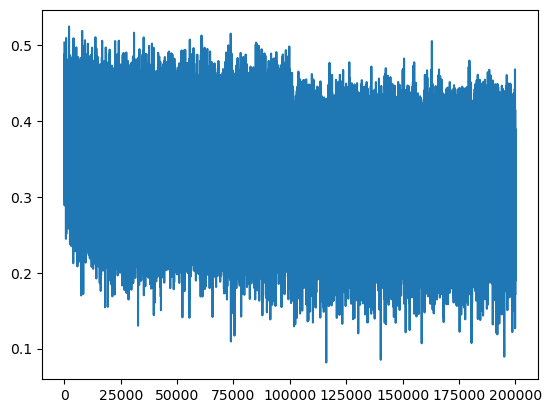

In [42]:
# improved (new initialisation):
plt.plot(lossi)

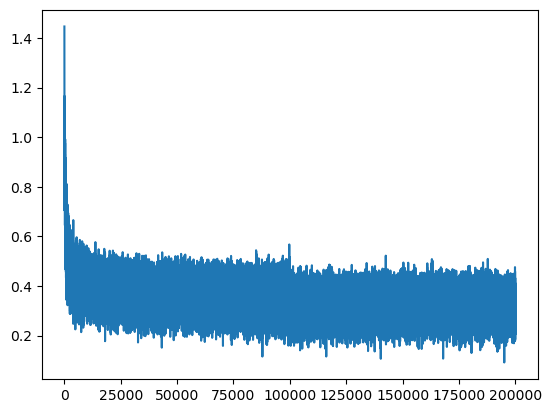

In [24]:
# original 
plt.plot(lossi)

### scores

In [103]:
# calibrate batch mean 

@torch.no_grad() # disables gradient tracking
def split_loss(split): 
    # get data segment and compute loss 

    # the code selects the appropriate dataset (training, validation, or test) 
    # based on the value of split and assigns the 
    # corresponding features and labels to x and y.
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte), 
    }[split]
    emb = C[x] # (N, block size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    
    hpreact = embcat @ W1 + b1
  # batch normalisation at init + scale and shift
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact) # (32, 100) hidden layer 
    
    logits = h @ W2 + b2 # (N, vocab size)
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())

print(split_loss('train'))
print(split_loss('val'))

('train', 2.066694736480713)
('val', 2.1048126220703125)


In [96]:
# fixed intialisation problem: w kaiming init 

@torch.no_grad() # disables gradient tracking
def split_loss(split): 
    # get data segment and compute loss 

    # the code selects the appropriate dataset (training, validation, or test) 
    # based on the value of split and assigns the 
    # corresponding features and labels to x and y.
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte), 
    }[split]
    emb = C[x] # (N, block size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2 # (N, vocab size)
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())

print(split_loss('train'))
print(split_loss('val'))

('train', 2.0376641750335693)
('val', 2.106989622116089)


In [43]:
# fixed intialisation problem: 
# new adjusted weights (at logits layer)

@torch.no_grad() # disables gradient tracking
def split_loss(split): 
    # get data segment and compute loss 

    # the code selects the appropriate dataset (training, validation, or test) 
    # based on the value of split and assigns the 
    # corresponding features and labels to x and y.
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte), 
    }[split]
    emb = C[x] # (N, block size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2 # (N, vocab size)
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())

print(split_loss('train'))
print(split_loss('val'))


('train', 2.0695769786834717)
('val', 2.131199836730957)


In [34]:
# first result
@torch.no_grad() # disables gradient tracking
def split_loss(split): 
    # get data segment and compute loss 

    # the code selects the appropriate dataset (training, validation, or test) 
    # based on the value of split and assigns the 
    # corresponding features and labels to x and y.
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte), 
    }[split]
    emb = C[x] # (N, block size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2 # (N, vocab size)
    loss = F.cross_entropy(logits, y)
    return (split, loss.item())

print(split_loss('train'))
print(split_loss('val'))
# print(split_loss('test'))

('train', 2.1183605194091797)
('val', 2.160410165786743)
('test', 2.1606833934783936)


# Sample from model (qual evaluation)

In [35]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size, n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift context window
      context = context[1:] + [ix]
      out.append(ix)
      # break if '.' sampled
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mrex.
taty.
skaelane.
mahnen.
amerync.
kaeli.
nerikia.
chaiir.
kaleigh.
ham.
jorn.
quint.
saline.
liveni.
watell.
dearixi.
jaxee.


# MLP analysis (notes)

### initialising loss problem

- at initialisation : we should have a rough idea of the loss (based on loss function and problem set up)

- in this case: 
    - consider no prior knowledge of what should come next 
    - it should assign a uniform distirbution to next token probabilities
    - hence prob should be 1/27 
    - hence loss should be log(1/27) = 3.29

- but in our case its at 27.. very far

- solution: 
    - set b as 0
    - set weights of logits layer (final layer) to lower number *0.01

- SIDE NOTES/ QUESTOINS: 
    - why reduce values of the logits layer; 
    - why is it dangerous to set weights to 0; preferrably smaller weight values than 0
        - for some variation / diversity / entropy at initialisation
        - prevent risk of vanishing gradients .. / saturated activation functions? 

- concept: symmetry breaking?

- a better initialisation, can improve efficiency of training, and improve training results

- new results: 
('train', 2.0695769786834717)
('val', 2.131199836730957)

In [38]:
## tiny problem exp; 
# conclusion: we want logits to be close to zero 
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss


(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

### saturated tanh problem

- squashing of numbers by tanh is skewed towards 1.0 and -1.0

- consider distirbution of tanh : 
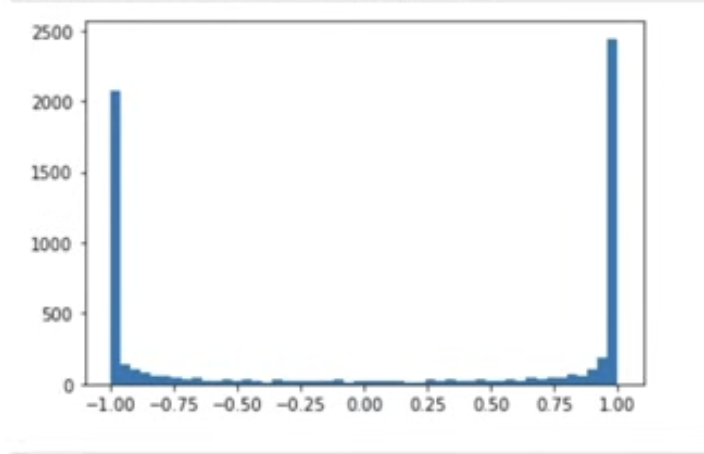


- this is a problem because : 
    - (1 - t**2) * out.grad
    - if t is -1 or 1 : it results in a 0 gradient (as expected, since being at the extremes of tanh,, any change in input, will not really affect the output of this tanh function)

- considering tanh: 
    - we observe that the gradient only ever decreases, 
    - at 0, gradient passes, at 1, gradient is 0 ? 
    
- conclusion: importance of good intialisation for effective training 
    - becomes more obvious especially when nn becomes more complex 

In [44]:
h.shape

torch.Size([32, 200])

In [46]:
# observe that there are many 1.0 and -1.0 values 
# hence a saturated tanh
h

tensor([[ 0.8875,  0.8216,  0.4165,  ..., -1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.7455,  0.1933,  ..., -0.9690,  1.0000, -0.7181],
        [-0.9997, -1.0000, -1.0000,  ...,  0.9998,  0.6852, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ...,  0.9998, -1.0000, -0.9380],
        [ 1.0000, -1.0000, -0.9994,  ..., -0.9999, -1.0000, -0.4910],
        [-1.0000, -1.0000, -1.0000,  ...,  1.0000, -0.8469, -0.9754]],
       grad_fn=<TanhBackward0>)

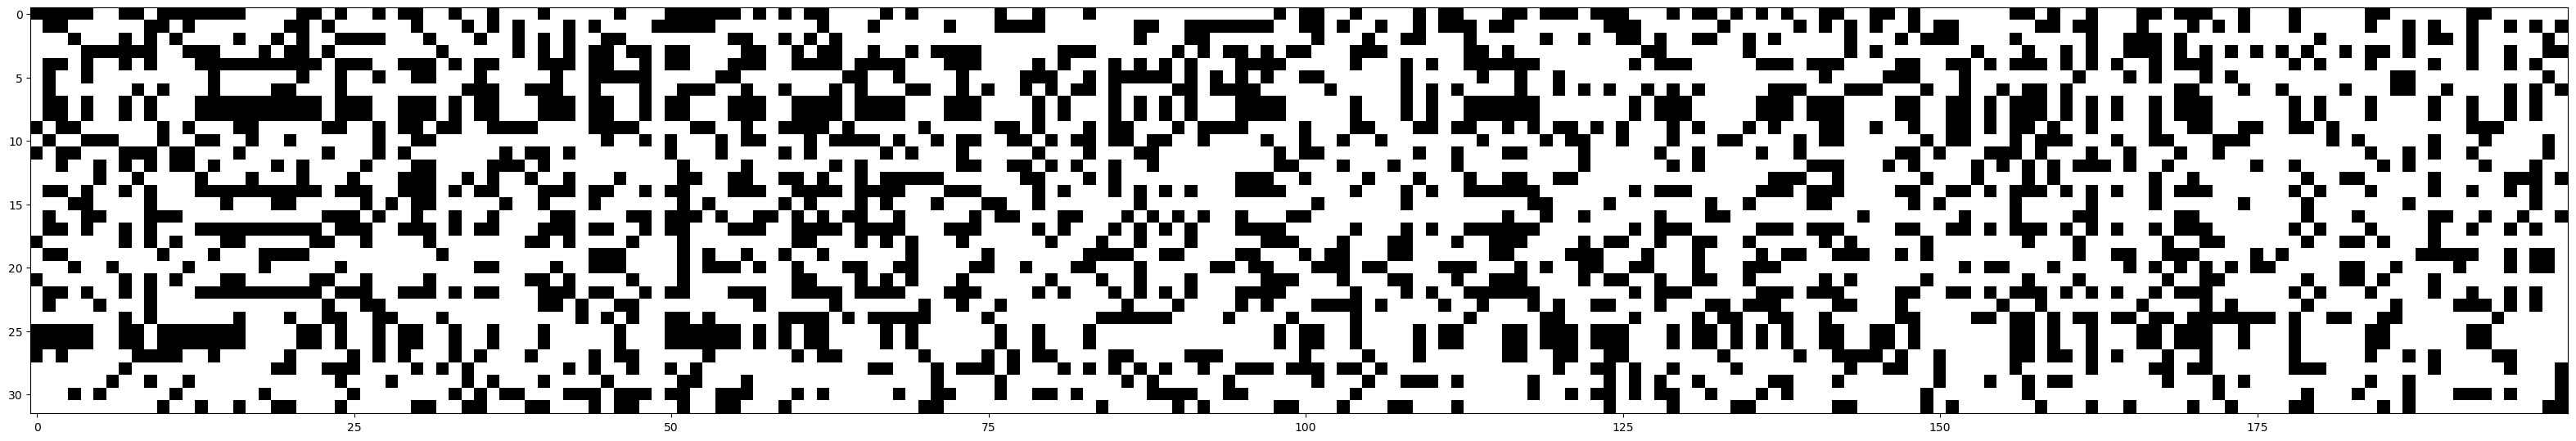

In [48]:
plt.figure(figsize=(40, 20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# if true : white = tanh is near 1, grad 0
# if entire column is white, suggests neuron is not learning ('dead')
# dead neuron: neuron that never activates, never learns 

In [52]:
h.view(-1).shape

torch.Size([6400])

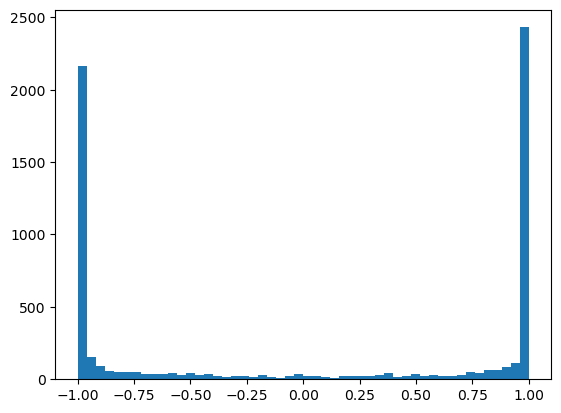

In [55]:
# squashed activations 
plt.hist(h.view(-1).tolist(), 50); # 50 bins

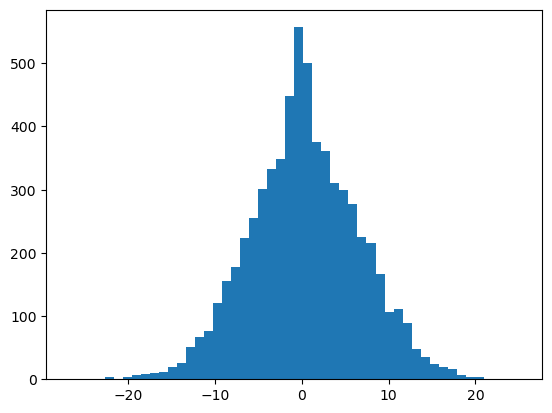

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50); 
# # consider the preactivation distribution; 
# rather wide 
# lets make it smaller - by setting weights to be smaller 

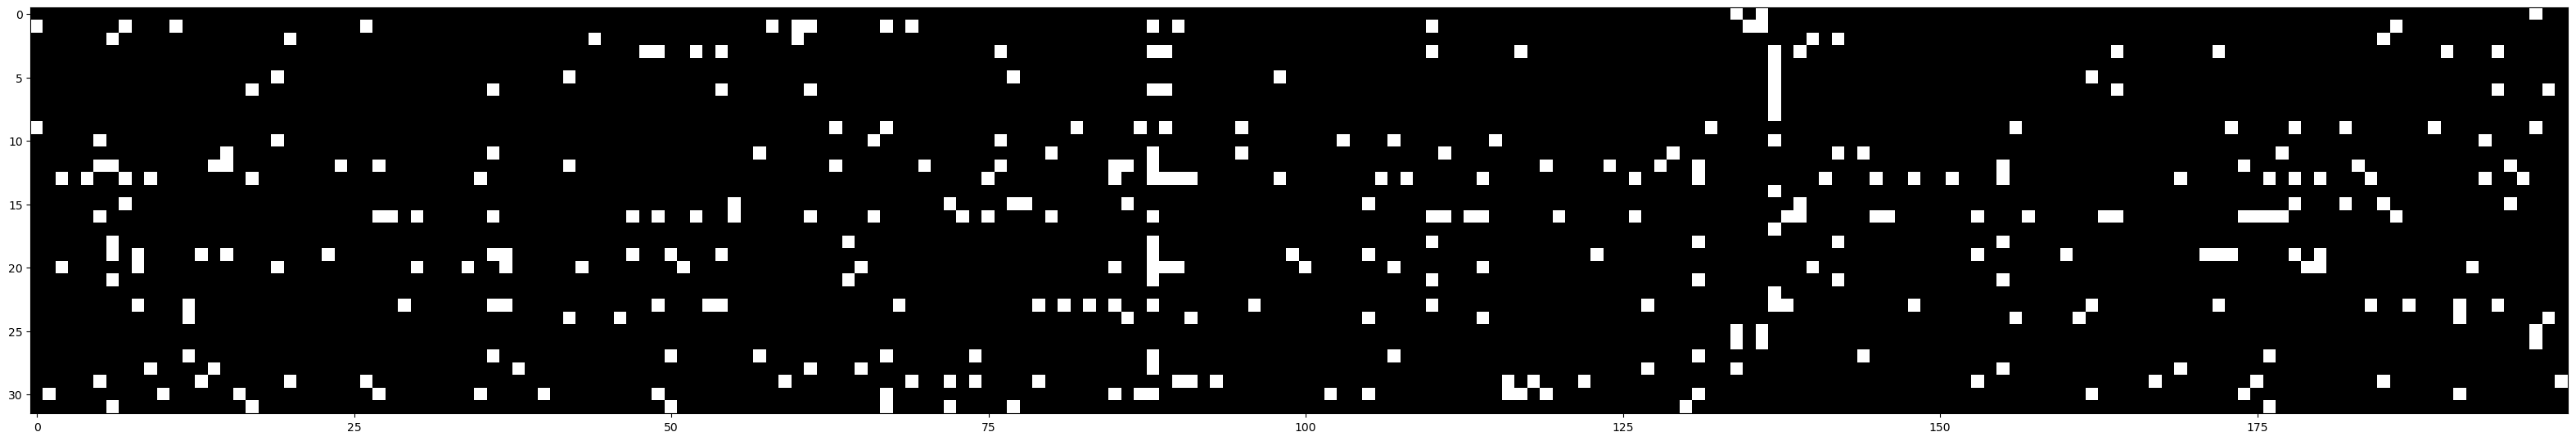

In [111]:
### reduce weights of (W1 * 0.2, b1 * 0.01)

## observe neuron activation
plt.figure(figsize=(40, 20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

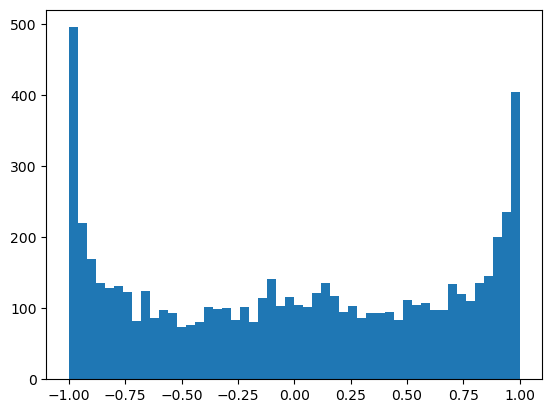

In [112]:
## observe 
plt.hist(h.view(-1).tolist(), 50);

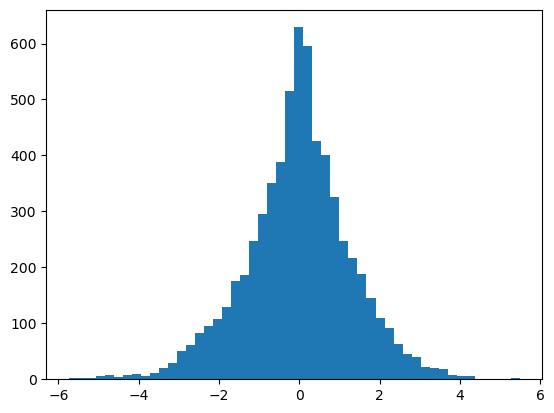

In [113]:
## observe pre activation 
plt.hist(hpreact.view(-1).tolist(), 50); 

## activation functions 
- notes: 
    - their limitations / with facing the 'saturation' issue, 
    - what are the extremities, limitations when it face extreme cases. 
    - esp if the function has a flat part - it will face this issue

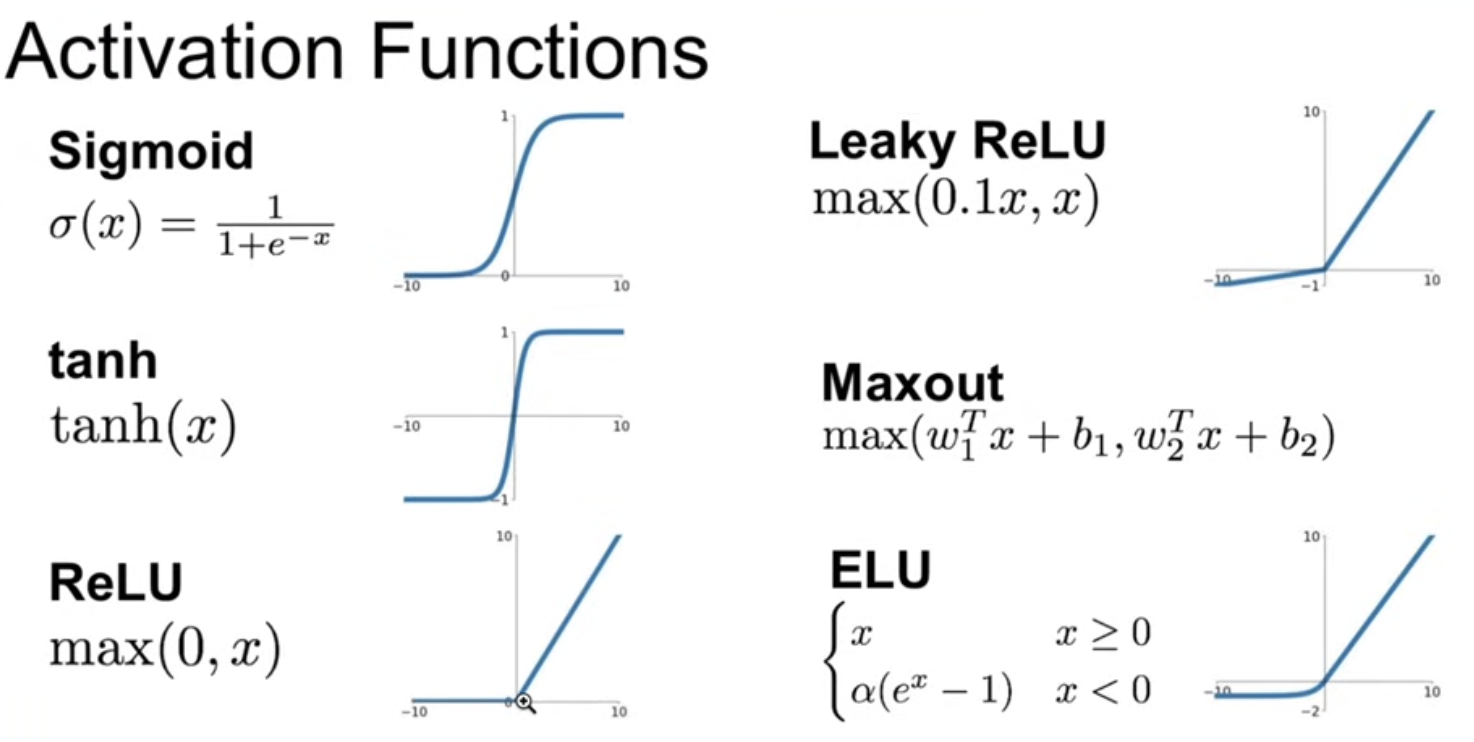

- sigmoid: 
    - faces same issue as tanh, give its shape (a squashing nature)

- reLU: 
    - a flat region below 0
    - if pre-activation is negative, grad is zero-ed out 
    - dead reLU neuron = if pre activation is all negative 
    - neuron hence never activations 

- leaky reLU: 
    - no flat tails, hence will not face the issue
- ELU: 
    - has a flat tail hence, will likely face the issue

dead neurons phenom: can happen, 

- during initialisation: 
    - if not initialised well / carefully 
- during training: 
    - if learning rate is too big; 

### How to ensure activations are well behaved throughout the network? 

### Method (old): how to best initialise neural networks weights? 
- kaiming initialisation, paper: https://arxiv.org/abs/1502.01852
    - how to keep ReLU activations well behaved
    - how to also ensure the gradients are well behaved: 
        - result: its shown that good weights initialisation will help w controlling the gradients

    - finding: gain / (fan_mode)**0.5
        - fan_in: input dimension (for maintaining weights)
        - fan_out: output dimension (for maintaining gradients)
    - finding: depending on the non-linearity activation, theres a recommended gain function

- why do we need a gain: 
    - for certain nonlinearity/act functions : they behave as a 'contractive' operation - (reduces the std dev?)

    - hence to fight the 'contraction', we need to reboost the weights, to bring it back to the previous distribution

- limitation: 
    - not scalable : would not work well esp with deep networks

#### Method (new): architectural innovations
- for neural net to have similar activations, can we preserve - unit gaussians through out the neural net

- modern innovations: reduce the problems with these initialisations / a need for precise calibration of NN
    - residual connnections 
    - batch normalisation
    - more complex optimisers 

#### current practise: 
- practical advice: 
    - initialise with fan_in
    - as std of weights as :  gain / sqrt (fan_in)
    - https://pytorch.org/docs/stable/nn.init.html

#### notes: 
- note how distribution changes w the functions

note: initial std dev
tensor(-0.0020) tensor(0.9925)

note: std dev after multiplication, linear operation
tensor(-0.0022) tensor(1.6433)

note: observe that mean remained (symmetric op), but std increased

 after tanh 
tensor(-0.0008) tensor(0.7422)


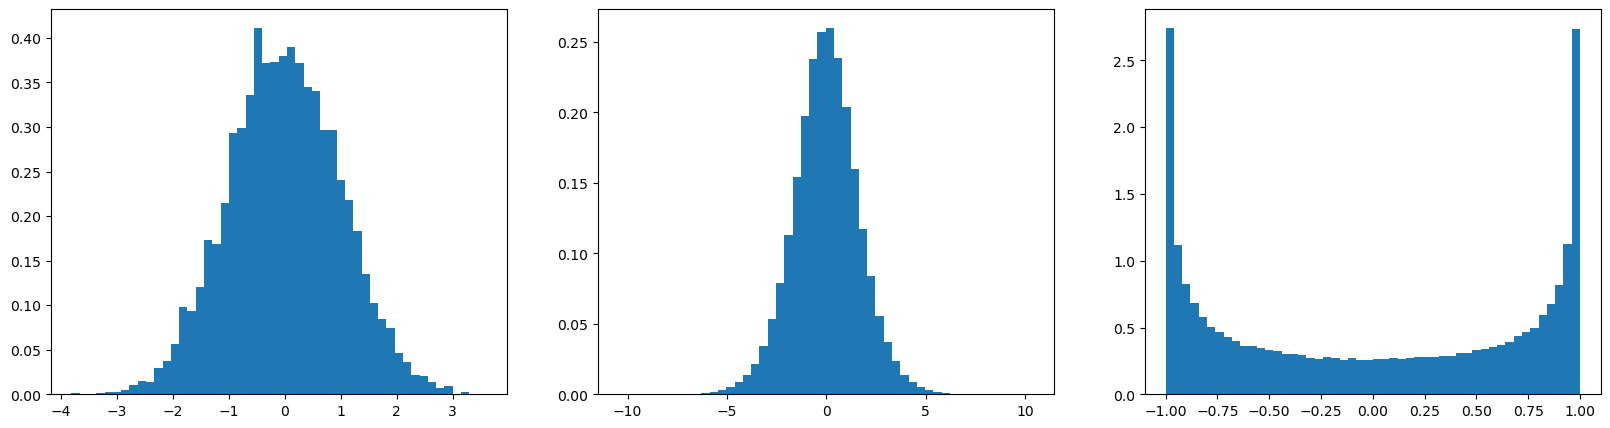

In [92]:
# observe how the distribution changes 
# # matrix multiplication: being a symmetric operation, mean remains the same 
# however standard deviation increases 

# QN: how do scale weights, so that we preserve the gaussian distribution of the data sets 

# 1000 data points, of 10 dimensions 
x = torch.randn(1000, 10)
# weights taking 10 inputs, w 200 neurons
w = torch.randn(10, 200) * ( (5/3) / 10**0.5 )
# / 10**0.5 

# linear 
y = x @ w 

z = torch.tanh(y) 
print('note: initial std dev')
print(x.mean(), x.std())
print()
print('note: std dev after multiplication, linear operation')
print(y.mean(), y.std())
print()
print('note: observe that mean remained (symmetric op), but std increased')
print('\n after tanh ')
print(z.mean(), z.std())

plt.figure(figsize=(20, 5))
plt.subplot(131) # (nrows, ncols, index)
plt.hist(x.view(-1).tolist(), 50, density=True);
# density: normalises histogram so that area under it = 1

plt.subplot(132)
plt.hist(y.view(-1).tolist(), 50, density=True);

# after tanh
plt.subplot(133)
plt.hist(z.view(-1).tolist(), 50, density=True);

# gaussian is expanding from the input 
# but we want neural net to have similar activations
# hence : we prefer unit gaussians through out the neural net
# TODO: why? to have well behaved activations so that they dont expand to infinity or shrink to zero 
# how to initalise the weights so that these activations stay within reasonable range throughout the network 
# kaiming init 

In [84]:
torch.randn(10000) * 0.2.std()
# spread of gaussian of mean 0 and unit std
# gain *

tensor(1.0049)

### method: Batch normalisation

- more scalable approach than kaimin init ; proved to be effective at controlling statistics of neural net

- why: effort to address effective initialisation

- how: addition of batch norm layer, after a linear / cnn layer, to have stabilise the training 

- what; 
    - technique (added layer) that normalises hidden layer 
    - to ensure gaussian (nice) intiilisation of hidden layer 
    - whilst allowing flexibility of weight distribution to be learnt during training time 

- why not: (limitation)
    - batch normalisation: now adds/captures, more info of the batch, into the training
    - couples the examples within the batch.
    - whilst, previously, batch norm is just for efficiency

    - however, its good: acts as a regulariser, arguably a way of data augmentation
    - prevents overfitting

others: 
    - layer norm... instance norm.. etc. 

#### notes 
- why; enabled training of deep nn, more reliably 
- https://arxiv.org/pdf/1502.03167

- question: how to achieve a gauss dist for the hidden layers 
- claim/answer: take hidden states and normalise them to be gaussian
    - can be done because, its a differentiable operation

- question 2: 
- we want them to be gaussian only at intialisation but not at training 
- hence: a need to add "scale and shift" - for flexibilty
    - batch norm gain * value + btach norm bias 

using batch norm layer: 
usually layers after multiplication (eg. linear layers/ convolutional layers)

QUESITON: how did they prove their point? that this makes sense

- using a running method, to estimate the batch mean / std instead 


sidenote: 
- with norm layer, no need bias of the previous layer, (since it will be subtracted off); batch norm introduces bias instead

### how then to run inference? 
- calibrate batch norm: at end of trainng 
- calibrate batch norm: during training (in a running manner)

### limitation: 
- coupling of data information within batches of data
- it might affect parallelism? 

### alternatives: 
- group normalisation
- layer normalisation


### eg: resnet
- application of batch norm? 
- for image classification 
- residual network archi: 
    - convolution 
    - batch norm 
    - non linearity


    

### pytorch

- batchnorm1d: 
    - large batch size -> will be roughly same mean; 0.1 momentum would be still ok
    - but if batch size is small (eg. 32), momentum 0.1 would be too big / cause much fluctuations / makes it difficult to stabilise

## Summary: 
- pytorch mdoel
- training
- viz activation stats forward
- viz activation stats backward

- eval
- sampling 

In [ ]:
# dimensionality of char embedding space 
# neuron of hidden layers
n_embd = 10
n_hidden = 200
vocab_size = len(itos) # dictionary

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),              generator=g) 
## initialisation technique: to keep weights more controlled/stable (closer to unit gaussian)
## considered based on activation function's impact on layer's input vs output distribution
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3) / ((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
## NOTE: set weights to be smaller, bias to be 0, so that initial loss is smaller
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# batch normalisation: layer parameters 
# at backprop, these are tuned
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# running 
bngain

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total)
for p in parameters:
  p.requires_grad = True

In [110]:
(torch.randn((10, 10), generator=g)).nelement()

100

In [ ]:
# linear 
class Linear: 

    def __init__(self, fan_in, fan_out, bias=True): 
        # initialise weights w kaimin
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x): 
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self): 
        # just to return parameters
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm 
    # eps
    # momentum 
    # training 

    # parameters (gamma, beta); trained w back prop 


# tanh activation 
    # 


In [ ]:
# TODO: the idea / method of running mean / std; why it works 

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

  # forward pass
  emb = C[Xb] # (32, 3, 10) embed characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate vectors 
  hpreact = embcat @ W1 + b1
  # running stats 
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)

  # batch normalisation at init + scale and shift
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  
  h = torch.tanh(hpreact) # (32, 100) hidden layer 
  logits = h @ W2 + b2 # (32, 27) output layer 
  loss = F.cross_entropy(logits, Yb) # loss function
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
## TODO: altho rand seed is set, still theres differences, 
# where is it coming from

# 1.81

### viz: forward pass 

### viz: backward pass 

# Summary: 
- (TO REVIEW) use of batch normalisation: 
    - for stable, effective training 

    - * importance of noting distributions, 

- (TBC) pytorchify code: into modules 
    - 

- (TBC) diagnostic tools to understand health of neural network dynamically 
    - 

# Next steps: 
- RNN 

## questions: 

- importance of statistics of activations and gradients 
- on the impact/effects on training 
